In [1]:
%cd ~/github/liz.9.11.19_GMVLE/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from utils.utils import read_vcf


PATH_RAW = 'data/raw/'
PATH_INTERIM = 'data/interim/'
PATH_PROCESSED = 'data/processed/'

/Users/maartenbiolizard/GitHub/liz.9.11.19_GMVLE


In [2]:
data_name = "HG003_NA24149_Ashkenazim_father.trim."
callers = ["dv", "fb", "oc", "st"]

for caller in callers:
    if not os.path.exists(PATH_INTERIM + caller + ".csv"):
        file_name = PATH_RAW + data_name + caller + ".vcf"
        data = read_vcf(file_name)
        data.to_csv(PATH_INTERIM + caller + ".csv", index=False)
        print(f"Saved {caller}.csv")
    else:
        print(f"{caller}.csv already exists")

benchmark = "HG003_GRCh38_1_22_v4.2.1_benchmark"
if not os.path.exists(PATH_INTERIM + benchmark + ".csv"):
    file_name = PATH_RAW + benchmark + ".vcf"
    benchmark = read_vcf(file_name)
    benchmark.to_csv(PATH_INTERIM + benchmark + ".csv", index=False)
    print(f"Saved {benchmark}")
else:
    print(f"{benchmark} already exists")

dv.csv already exists
fb.csv already exists
oc.csv already exists
st.csv already exists
HG003_GRCh38_1_22_v4.2.1_benchmark already exists


In [3]:
def data_expl(data: pd.DataFrame, caller: str):
    display(data["CHROM"].value_counts())
#    print(data["FILTER"].value_counts())
#    print(data["INFO"].value_counts())
    plt.hist(data["QUAL"].fillna(0), bins=100)
    plt.title(f"QUAL {caller}")
    plt.show()

def get_values_from_format(data: pd.DataFrame, format_column:str = "FORMAT", value_column:str = "HG003_NA24149_Ashkenazim_father.trim") -> pd.DataFrame:

    dict_error = {}

    # Assume that the FORMAT column is a string with the values separated by ":", and is the same for all rows
    # check if FORMAT column is unique
    if data[format_column].nunique() == 1:
        print("FORMAT column is unique")

        value_names = data[format_column].iloc[0].split(":")

        # split the value column by ":", and convert it to separate columns
        values = data[value_column].str.split(":", expand=True)
        values.columns = value_names

        # drop the original value column and concatenate the new columns
        data = data.drop(value_column, axis=1).drop(format_column, axis=1)
        data_new = pd.concat([data, values], axis=1).copy()

    else:
        print("FORMAT column is not unique")

        # convert the format_column and value_column to a dict per row
        format_dict = {}

        for row in data.iterrows():
            
            # get row index and values
            index = row[0]

            values = row[1][value_column].split(":")
            cols = row[1]["FORMAT"].split(":")

            if len(values) != len(cols):
                # Different lengths at this row
                if row[1]["CHROM"] not in dict_error:
                    dict_error[row[1]["CHROM"]] = [row[1]["POS"]]
                else:
                    dict_error[row[1]["CHROM"]].append(row[1]["POS"])

                # add empty values to match the length of cols
                values += [np.nan] * (len(cols) - len(values))

            format_dict[index] = dict(zip(cols, values))

        # drop the original value column and concatenate the new columns
        data = data.drop(value_column, axis=1).drop(format_column, axis=1)
        data_new = data.merge(pd.DataFrame(format_dict).T, left_index=True, right_index=True).copy()

        print("Different lenght at CHROM: positions\n", dict_error)

    return data_new

In [4]:
def process_vcf_data(callers = [], benchmark = None):

    dtype = {
        "CHROM": str,
        "POS": int,
        "ID": str,
        "REF": str,
        "ALT": str,
        "QUAL": float,
        "FILTER": str,
        "INFO": str,
        "FORMAT": str,
        "HG003_NA24149_Ashkenazim_father.trim": str,
        "HG003": str,
    }

    cols_to_keep = ["CHROM", "POS", "REF", "ALT", "QUAL", "FILTER", # original columns
                    "DP", # "GT", "GQ" columns from FORMAT
                    ]

    for caller in callers:

        if not os.path.exists(PATH_PROCESSED + caller + ".csv"):
            print(f"Processing {caller}.csv")
            data = pd.read_csv(PATH_INTERIM + caller + ".csv", dtype=dtype, na_values=".")
            data_new = get_values_from_format(data)[cols_to_keep]
            data_new.to_csv(PATH_PROCESSED + caller + ".csv", index=False)
            display(data_new.head())

        else:
            print(f"{caller}.csv already processed")

    if benchmark is not None:
        if not os.path.exists(PATH_PROCESSED + benchmark + ".csv"):
            print(f"Processing {benchmark}.csv")
            data = pd.read_csv(PATH_INTERIM + benchmark + ".csv", dtype=dtype, na_values=".")
            data_new = get_values_from_format(data, value_column="HG003")[cols_to_keep]

            # remove "chr" from CHROM column to match the other data
            data_new["CHROM"] = data_new["CHROM"].str.replace("chr", "")

            data_new.to_csv(PATH_PROCESSED + benchmark + ".csv", index=False)
            display(data_new.head())

        else:
            print(f"{benchmark}.csv already processed")

process_vcf_data(callers, benchmark)

dv.csv already processed
fb.csv already processed
oc.csv already processed
st.csv already processed
HG003_GRCh38_1_22_v4.2.1_benchmark.csv already processed


In [5]:
from functools import reduce

dtype = {
    "CHROM": str,
    "POS": int,
    "REF": str,
    "ALT": str,
    "QUAL": float,
    "FILTER": str,
    "DP": pd.Int64Dtype(),
}



# Merge the dataframes on CHROM and POS
# Columns that are required to be the same in all dataframes: REF, DP
# Columns that are specific to the caller: ALT, QUAL, FILTER
def merge_dataframes(caller_names: list, on: list, same_col: list) -> pd.DataFrame:
    
    file_name = PATH_PROCESSED + "merged.csv"
    if not os.path.exists(file_name):
        print("Merging dataframes")

        dataframes = [pd.read_csv(PATH_PROCESSED + caller + ".csv", dtype=dtype) for caller in caller_names]

        # Create the merged dataframe
        for caller, df in zip(caller_names, dataframes):
            df.columns = [col + f"_{caller}" if col not in on else col for col in df.columns]

        df_merged = reduce(lambda left, right: pd.merge(left, right, on=on, how="outer"), dataframes)

        # Check if the data in the same columns is the same when it's not NaN

        for col in same_col:
            df_merged[f"{col}_same"] = df_merged[[f"{col}_{caller}" for caller in caller_names]].apply(lambda x: len(set(x.dropna())) == 1, axis=1)

        # Save the dataframe
        df_merged.to_csv(file_name, index=False)

    else:
        print("Merged dataframe already exists")
        df_merged = pd.read_csv(file_name, dtype=dtype)

    return df_merged

df_merged = merge_dataframes(callers, on=["CHROM", "POS"], same_col=["REF", "DP"])
df_merged.head()

Merged dataframe already exists


,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,QUAL_oc,FILTER_oc,DP_oc,REF_st,ALT_st,QUAL_st,FILTER_st,DP_st,REF_same,DP_same
0,1,10103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,T,A,0.0,LowGQX;NoPassedVariantGTs,12.0,True,True
1,1,10105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,C,0.0,LowGQX;NoPassedVariantGTs,16.0,True,True
2,1,10120,T,C,0.0,RefCall,127.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
3,1,10126,T,C,0.0,RefCall,116.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,1,10132,T,C,0.0,RefCall,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True


In [6]:
dtype = {
    "CHROM": str,
    "POS": int,
    "REF": str,
    "ALT": str,
    "QUAL": float,
    "FILTER": str,
    "DP": pd.Int64Dtype(),
}

df_benchmark = pd.read_csv(PATH_PROCESSED + benchmark + ".csv", dtype=dtype)
def merge_benchmark(df_benchmark, df_merged, on=["CHROM", "POS"]) -> pd.DataFrame:
    file_name = PATH_PROCESSED + "merged_benchmark.csv"
    if not os.path.exists(file_name):
        print("Merging benchmark")
        df_benchmark.columns = [col + "_BM" if col not in ["CHROM", "POS"] else col for col in df_benchmark.columns]

        # Select only the chromosomes that are in the benchmark
        chromosomes = df_benchmark["CHROM"].unique()
        df_merged = df_merged[df_merged["CHROM"].isin(chromosomes)]

        df_merged = pd.merge(df_merged, df_benchmark, on=on, how="outer")
        df_merged.to_csv(file_name, index=False)

    else:
        print("Merged benchmark already exists")
        df_merged = pd.read_csv(file_name, dtype=dtype)

    # print the number of rows per chromosome
    print("Number of rows per chromosome")
    display(df_merged["CHROM"].value_counts())

    return df_merged

df_merged_BM = merge_benchmark(df_benchmark, df_merged)
df_merged_BM.head()

Merged benchmark already exists


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_3240/3682729856.py:27: DtypeWarning: Columns (22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv(file_name, dtype=dtype)


Number of rows per chromosome


CHROM
1     981778
2     971246
3     782302
4     756881
7     719057
6     707193
5     704690
10    628570
12    601145
8     591362
11    585413
9     561585
17    456086
16    427742
19    417570
13    396878
14    385585
15    378263
18    340268
20    328338
22    237992
21    192540
Name: count, dtype: int64

,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,QUAL_st,FILTER_st,DP_st,REF_same,DP_same,REF_BM,ALT_BM,QUAL_BM,FILTER_BM,DP_BM
0,1,10103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,LowGQX;NoPassedVariantGTs,12.0,True,True,NaN,NaN,NaN,NaN,NaN
1,1,10105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,LowGQX;NoPassedVariantGTs,16.0,True,True,NaN,NaN,NaN,NaN,NaN
2,1,10120,T,C,0.0,RefCall,127.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
3,1,10126,T,C,0.0,RefCall,116.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
4,1,10132,T,C,0.0,RefCall,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN


In [45]:
df_merged_BM_path = PATH_PROCESSED + "merged_benchmark.csv"
df_merged_BM = pd.read_csv(df_merged_BM_path)

# write "call" as a method to apply to the dataframe
conf = {
    "dv": {"y": "FILTER", "call": "PASS"},
    "fb": {"y": "ALT", "call": 'notna' },
    "oc": {"y": "FILTER", "call": "PASS"},
    "st": {"y": "FILTER", "call": "PASS"},
    "BM": {"y": "FILTER", "call": "PASS"},
    "keys": ["CHROM", "POS"],
    "features": ["QUAL", "DP"],
}

/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_3240/1733362859.py:2: DtypeWarning: Columns (22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged_BM = pd.read_csv(df_merged_BM_path)


In [48]:
def label_caller_data(df_merged_BM, conf, callers: list, benchmark: str = "BM", how = "all", features = []) -> pd.DataFrame:

    assert type(callers) == list, "callers must be a list"

    methods = callers + [benchmark]

    callers_cols = [f"{conf[method]['y']}_{method}" for method in callers]
    methods_cols = [f"{conf[method]['y']}_{method}" for method in methods]
    features_cols = [f"{feature}_{caller}" for feature in features for caller in callers]

    df_call = df_merged_BM.copy()[conf["keys"] + methods_cols + features_cols].set_index(conf["keys"])

    # drop rows with nan values in all columns
    df_call.dropna(axis = 0, how="all", inplace=True, subset=methods_cols)

    # assign the boolean labels to the data based on the call configuration
    for method in methods:
        y = conf[method]["y"]
        call = conf[method]["call"]

        if call == "notna":
            df_call[f"{y}_{method}"] = df_call[f"{y}_{method}"].notna()
        elif call == "PASS":
            df_call[f"{y}_{method}"] = df_call[f"{y}_{method}"] == "PASS"
        else:
            print("Invalid call:", call)
    
    # rename prediction to y_hat: if there are multiple callers, create a consensus column
    if how == "all":
        df_call["y_hat"] = df_call[callers_cols].all(axis=1)
    elif how == "majority":
        df_call["y_hat"] = df_call[callers_cols].sum(axis=1) > len(callers) / 2
    elif how == "any":
        df_call["y_hat"] = df_call[callers_cols].any(axis=1)
    elif how == "per_caller":
        for caller in callers:
            df_call[f"y_hat_{caller}"] = df_call[f"{conf[caller]['y']}_{caller}"]


    # rename the benchmark column to y
    df_call["y"] = df_call[f"{conf[benchmark]['y']}_{benchmark}"]

    if how == "per_caller":
        df_call = df_call[[f"y_hat_{caller}" for caller in callers] + ["y"] + features_cols]
    
    else:
        # keep only the benchmark column (true call) and the predicted column (y_hat)
        df_call = df_call[["y", "y_hat"] + features_cols]

    return df_call
        

def calculate_performance(df_call, callers: list, true_label:str = "y", pred:str = "y_hat"):

    print(f"Calculating performance metrics for {callers}")

    caller_bool = df_call[pred]
    benchmark_bool = df_call[true_label]

    # True Positives (TP)
    TP = (caller_bool & benchmark_bool)
    
    # False Positives (FP)
    FP = (caller_bool & ~benchmark_bool)
    
    # False Negatives (FN)
    FN = (~caller_bool & benchmark_bool)

    # True Negatives (TN) are not applicable: the benchmark only contains the positive cases

    # Performance metrics
    TP_count = TP.sum()
    FP_count = FP.sum()
    FN_count = FN.sum()

    precision = TP_count / (TP_count + FP_count)
    recall = TP_count / (FN_count + TP_count)
    F1 = 2 * precision * recall / (precision + recall)

    TP_baseline = benchmark_bool.sum()

    # create a dictionary with the performance metrics

    performance = {
        "caller": ", ".join(callers),
        "True-pos-baseline": TP_baseline,
        "True-pos-call": TP_count,
        "False-pos": FP_count,
        "False-neg": FN_count,
        "Precision": round(precision, 4),
        "Sensitivity": round(recall, 4),
        "F-measure": round(F1, 4),
    }

    return performance


------------------------------------------------------------------------------------------------

In [39]:
list_of_dfs = []

for caller in callers:
    df_call = label_caller_data(df_merged_BM, conf, [caller])
    performance = calculate_performance(df_call, [caller])

    # add performance metrics as a df row to the table
    list_of_dfs.append(pd.DataFrame(performance, index=["custom"]))

for how in ["all", "majority", "any"]:
    df_call = label_caller_data(df_merged_BM, conf, callers, how=how)
    performance = calculate_performance(df_call, callers)
    list_of_dfs.append(pd.DataFrame(performance, index=[how]))

# create a table with the performance metrics
df_performance = pd.concat(list_of_dfs, axis=0)
# df_performance.set_index("caller", inplace=True)
df_performance

Calculating performance metrics for ['dv']
{'caller': 'dv', 'True-pos-baseline': np.int64(4005201), 'True-pos-call': np.int64(3972233), 'False-pos': np.int64(732942), 'False-neg': np.int64(32968), 'Precision': np.float64(0.8442), 'Sensitivity': np.float64(0.9918), 'F-measure': np.float64(0.9121)}
Calculating performance metrics for ['fb']
{'caller': 'fb', 'True-pos-baseline': np.int64(4005201), 'True-pos-call': np.int64(3873139), 'False-pos': np.int64(1163685), 'False-neg': np.int64(132062), 'Precision': np.float64(0.769), 'Sensitivity': np.float64(0.967), 'F-measure': np.float64(0.8567)}
Calculating performance metrics for ['oc']
{'caller': 'oc', 'True-pos-baseline': np.int64(4005201), 'True-pos-call': np.int64(3947129), 'False-pos': np.int64(737402), 'False-neg': np.int64(58072), 'Precision': np.float64(0.8426), 'Sensitivity': np.float64(0.9855), 'F-measure': np.float64(0.9085)}
Calculating performance metrics for ['st']
{'caller': 'st', 'True-pos-baseline': np.int64(4005201), 'True-

,caller,True-pos-baseline,True-pos-call,False-pos,False-neg,Precision,Sensitivity,F-measure
custom,dv,4005201,3972233,732942,32968,0.8442,0.9918,0.9121
custom,fb,4005201,3873139,1163685,132062,0.7690,0.9670,0.8567
custom,oc,4005201,3947129,737402,58072,0.8426,0.9855,0.9085
custom,st,4005201,3952864,617727,52337,0.8648,0.9869,0.9219
all,"dv, fb, oc, st",4005201,3834073,374470,171128,0.9110,0.9573,0.9336
majority,"dv, fb, oc, st",4005201,3954885,573154,50316,0.8734,0.9874,0.9269
any,"dv, fb, oc, st",4005201,3982791,1486166,22410,0.7283,0.9944,0.8408


In [40]:
DIR_VCFEVAL = "data/vcfeval"
experiment = "withoutseq_qual"

for caller in callers:
    # get the summary file
    file_name = f"{DIR_VCFEVAL}/vcfeval_{caller}_{experiment}/summary.txt"

    # print the summary
    with open(file_name, "r") as file:
        lines = file.readlines()
        
        # drop line with '---'
        lines = [line for line in lines if not line.startswith("---")]
        print(f"Summary for {caller}")
        
        # put lines in a table
        table = [line.split() for line in lines]
        df = pd.DataFrame(table[1:], columns=table[0])

        # keep only threshold == None
        df = df[df["Threshold"] == "None"]
        df.index = ["vcfeval"] * len(df)
        df["caller"] = caller
        
        # concat 
        df_performance = pd.concat([df_performance, df])
    
df_performance.sort_values("caller", ascending=False)

Summary for dv
Summary for fb
Summary for oc
Summary for st


,caller,True-pos-baseline,True-pos-call,False-pos,False-neg,Precision,Sensitivity,F-measure,Threshold
custom,st,4005201,3952864,617727,52337,0.8648,0.9869,0.9219,NaN
vcfeval,st,3945375,3947418,695789,54685,0.8501,0.9863,0.9132,None
custom,oc,4005201,3947129,737402,58072,0.8426,0.9855,0.9085,NaN
vcfeval,oc,3948638,3982730,814979,51416,0.8301,0.9871,0.9019,None
custom,fb,4005201,3873139,1163685,132062,0.769,0.967,0.8567,NaN
vcfeval,fb,3915360,3833593,1202574,84700,0.7612,0.9788,0.8564,None
all,"dv, fb, oc, st",4005201,3834073,374470,171128,0.911,0.9573,0.9336,NaN
majority,"dv, fb, oc, st",4005201,3954885,573154,50316,0.8734,0.9874,0.9269,NaN
any,"dv, fb, oc, st",4005201,3982791,1486166,22410,0.7283,0.9944,0.8408,NaN
custom,dv,4005201,3972233,732942,32968,0.8442,0.9918,0.9121,NaN


# Random Forest Classifier

## Load the data

In [50]:
df_call = label_caller_data(df_merged_BM, conf, callers=callers, how="per_caller", features=["QUAL", "DP"])

y = df_call["y"]
X = df_call.drop("y", axis=1)

## Split the data into training and testing sets

In [109]:
from sklearn.model_selection import train_test_split

def select_data(X, y, chrom = None) -> tuple:

    if chrom is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    else:
        X_chrom = X.loc[X.index.get_level_values("CHROM") == chrom]
        y_chrom = y.loc[y.index.get_level_values("CHROM") == chrom]

        X_train, X_test, y_train, y_test = train_test_split(X_chrom, y_chrom, test_size=0.2, random_state=42)

    # print the amount of positive and negative cases in the training and test sets
    print("Training set")
    print(y_train.value_counts())
    print("Test set")
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

In [111]:
X_train, X_test, y_train, y_test = select_data(X, y)

Training set
y
False    6517242
True     3204344
Name: count, dtype: int64
Test set
y
False    1629540
True      800857
Name: count, dtype: int64


## Preprocess the data

In [112]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_train, X_test):
    
    # convert boolean columns to integers
    for col in X_train.columns:
        if X_train[col].dtype == bool:
            X_train[col] = X_train[col].astype(int)
            X_test[col] = X_test[col].astype(int)

    # fill QUAL with min value of the caller
    for caller in callers:
        minimal_qual = X_train[f"QUAL_{caller}"].min()

        X_train[f"QUAL_{caller}"] = X_train[f"QUAL_{caller}"].fillna(minimal_qual)
        X_test[f"QUAL_{caller}"] = X_test[f"QUAL_{caller}"].fillna(minimal_qual)

    # fill DP with the median value of all callers
    median_DP_train = X_train[[f"DP_{caller}" for caller in callers]].median(axis = 1)
    median_DP_test = X_test[[f"DP_{caller}" for caller in callers]].median(axis = 1)

    for caller in callers:
        X_train[f"DP_{caller}"] = X_train[f"DP_{caller}"].fillna(median_DP_train)
        X_test[f"DP_{caller}"] = X_test[f"DP_{caller}"].fillna(median_DP_test)
        
    # scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled

In [113]:
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train_scaled.head()

,,y_hat_dv,y_hat_fb,y_hat_oc,y_hat_st,QUAL_dv,QUAL_fb,QUAL_oc,QUAL_st,DP_dv,DP_fb,DP_oc,DP_st
CHROM,POS,,,,,,,,,,,,
18,30046474,1.258150,1.188639,1.262554,1.288053,1.041929,0.096628,0.836474,0.479468,0.229363,0.052043,0.125401,0.116323
1,204947667,-0.794818,-0.841298,-0.792046,-0.776366,-0.742133,-0.065072,-0.485426,-0.592181,0.072282,0.012047,0.033105,0.047278
9,35524902,-0.794818,-0.841298,-0.792046,-0.776366,-0.742133,-0.065072,-0.485426,-0.592181,0.090762,0.017047,0.043963,0.057901
4,176133258,1.258150,1.188639,-0.792046,1.288053,0.433149,-0.064872,-0.475257,0.334651,-0.260360,-0.127939,-0.151488,-0.143923
17,66502250,-0.794818,-0.841298,-0.792046,-0.776366,-0.742133,-0.065072,-0.485426,-0.592181,0.118482,0.024546,0.060251,0.073834


## Train the model

In [114]:
from sklearn.ensemble import RandomForestClassifier

def train_model(X_train, y_train):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    return clf

clf = train_model(X_train_scaled, y_train)

def evaluate_model(clf, X_test):
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba

y_pred, y_pred_proba = evaluate_model(clf, X_test_scaled, y_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y_test, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return accuracy, precision, recall, f1, roc_auc

accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_test, y_pred, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

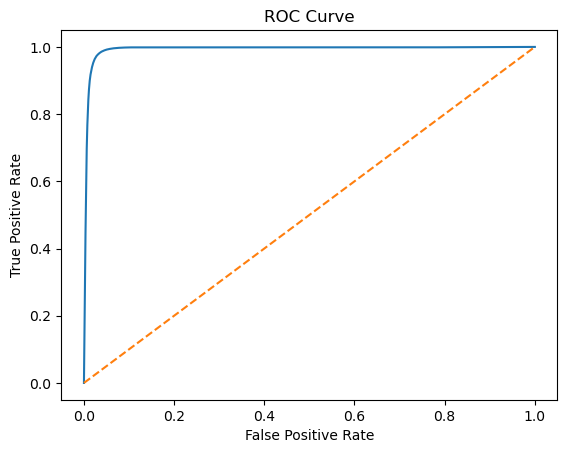

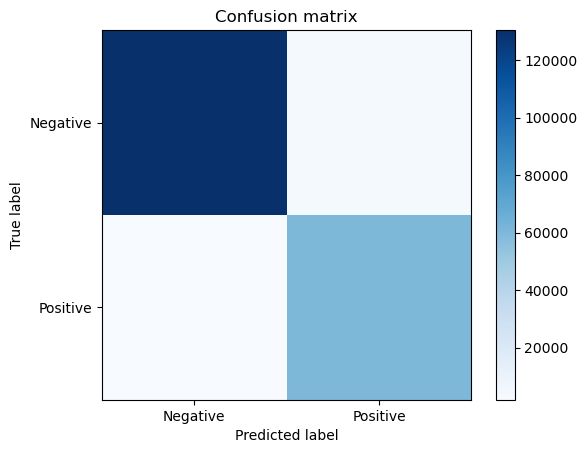

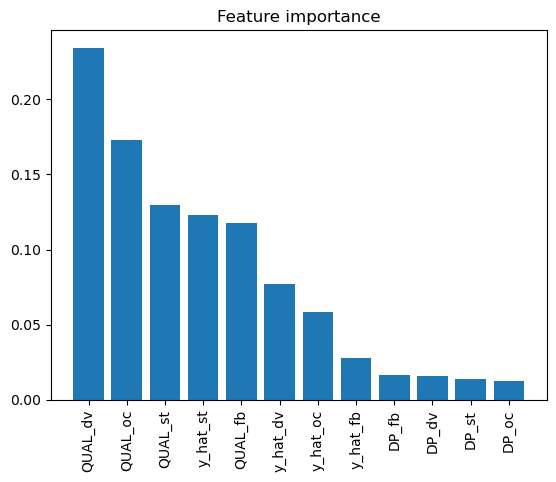

In [107]:
from sklearn.metrics import roc_curve

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

plot_roc_curve(y_test, y_pred_proba)

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()

    # Add the labels

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="black")

    plt.xticks([0, 1], ["Negative", "Positive"])
    plt.yticks([0, 1], ["Negative", "Positive"])

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.show()

plot_confusion_matrix(y_test, y_pred)

# feature importance
def plot_feature_importance(clf, X_train):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
    plt.title("Feature importance")
    plt.show()

plot_feature_importance(clf, X_train_scaled)